In [ ]:
!pip install transformers
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow
!pip install einops
!pip install wget
!pip install datasets

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package libcudnn8 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Version '8.1.0.77-1+cuda11.2' for 'libcudnn8' was not found
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 95.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=c5eb765bd476c5b16a31a324ba4a987be1de9f68cf80a19884560cf880acbb98
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c8

In [ ]:
import logging
import time
import numpy
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow_datasets as tfds
import tensorflow as tf
import pathlib
import tensorflow_text
from tensorflow.keras.layers import Layer , Embedding , MultiHeadAttention , LayerNormalization , Add , Dense , Dropout
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping
from tensorflow.keras import Model
from transformers import BertTokenizer
from tensorflow import keras

## Prepare Data


In [ ]:
from datasets import load_dataset
dataset = load_dataset("mt_eng_vietnamese", "iwslt2015-vi-en")

Generating train split:   0%|          | 0/133318 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1269 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1269 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 133318
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 1269
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 1269
    })
})

In [ ]:
train_data = dataset['train'].shuffle(seed = 42).select([*range(64000)])
val_data = dataset['validation'].select([*range(960)])
test_data = dataset['test']

In [ ]:
train_data

Dataset({
    features: ['translation'],
    num_rows: 64000
})

In [ ]:
def Generator():
  a = 1;
  for example in train_data['translation']:
    yield (
        example['en'] ,
        example['vi']
    )
def Generator_val():
  a = 1;
  for example in val_data['translation']:
    yield (
        example['en'] ,
        example['vi']
    )

In [ ]:
tf_dataset = tf.data.Dataset.from_generator(Generator, output_signature=(
     tf.TensorSpec(shape = () , dtype=tf.string),
     tf.TensorSpec(shape = () , dtype=tf.string)
))
tf_dataset_val = tf.data.Dataset.from_generator(Generator_val, output_signature=(
     tf.TensorSpec(shape = () , dtype=tf.string),
     tf.TensorSpec(shape = () , dtype=tf.string)
))

In [ ]:
batch_size = 32
tf_dataset = tf_dataset.shuffle(buffer_size= 100 , reshuffle_each_iteration= True).batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
tf_dataset_val = tf_dataset_val.shuffle(buffer_size= 100 , reshuffle_each_iteration= True).batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()

### Tokenzer

In [ ]:
vietnamese_tokenizer = BertTokenizer.from_pretrained("NlpHUST/vibert4news-base-cased")
english_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/411k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'BertTokenizer'.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
config = {
    'd_model' : 128,
    'vi_vocab_size' : vietnamese_tokenizer.vocab_size,
    'en_vocab_size' : english_tokenizer.vocab_size,
    'num_layers': 4,
    'num_heads': 8 ,
    'dropout_rate': 0.1,
    'dff': 256
}

In [ ]:
# Example English text
english_text = "Hugging Face's Transformers library is awesome!"

# Example Vietnamese text
vietnamese_text = "Thư viện Transformers của Hugging Face thật tuyệt vời!"

# Tokenize English text
english_tokens = english_tokenizer.encode(english_text)
english_ids = english_tokenizer.decode(english_tokens)

# Tokenize Vietnamese text
vietnamese_tokens = vietnamese_tokenizer.encode(vietnamese_text)
vietnamese_ids = vietnamese_tokenizer.decode(vietnamese_tokens)

# Print tokenized text and corresponding IDs
print("English Tokens:", english_tokens)
print("English IDs:", english_ids)

print("\nVietnamese Tokens:", vietnamese_tokens)
print("Vietnamese IDs:", vietnamese_ids)


English Tokens: [101, 17662, 2227, 1005, 1055, 19081, 3075, 2003, 12476, 999, 102]
English IDs: [CLS] hugging face's transformers library is awesome! [SEP]

Vietnamese Tokens: [2, 1855, 443, 20612, 8, 33277, 344, 5518, 878, 1313, 2115, 932, 3]
Vietnamese IDs: [CLS] Thư viện Transformers của Hugging Face thật tuyệt vời! [SEP]


### Handing Data

In [ ]:
def prepare_data(en_example , vi_example):
  Tabel_vi_id =list()
  Tabel_eng_id = list()
  for vi_text in vi_example.numpy():
    Tabel_vi_id.append(vietnamese_tokenizer(vi_text.decode('utf8'),truncation=True ,max_length=256)['input_ids'])
  for en_text in en_example.numpy():
    Tabel_eng_id.append(english_tokenizer(en_text.decode('utf8'),truncation=True ,max_length=256)['input_ids'])
  ragged_en_tensor = tf.ragged.constant(Tabel_eng_id)
  ragged_vi_label_tensor = tf.ragged.constant(Tabel_vi_id)
  ragged_vi_in_tensor = tf.ragged.constant(Tabel_vi_id)

  ragged_vi_label_tensor = ragged_vi_label_tensor[: ,1:]
  ragged_vi_in_tensor = ragged_vi_in_tensor[: , :-1]

  en_tensor = ragged_en_tensor.to_tensor()
  vi_in_tensor = ragged_vi_in_tensor.to_tensor()
  vi_label_tensor = ragged_vi_label_tensor.to_tensor()

  return (en_tensor , vi_in_tensor) , vi_label_tensor

In [ ]:
def pipeline_dataset():
  for en_example , vi_example in tf_dataset:
    yield prepare_data(en_example, vi_example)

def pipeline_dataset_val():
  for en_example , vi_example in tf_dataset_val:
    yield prepare_data(en_example, vi_example)

In [ ]:
tf_train_data = tf.data.Dataset.from_generator(pipeline_dataset, output_signature=(
     (tf.TensorSpec(shape = (batch_size, None) , dtype=tf.int32),
     tf.TensorSpec(shape = (batch_size , None) , dtype=tf.int32)),
     tf.TensorSpec(shape = (batch_size , None) , dtype=tf.int32)
))
tf_val_data = tf.data.Dataset.from_generator(pipeline_dataset_val, output_signature=(
     (tf.TensorSpec(shape = (batch_size, None) , dtype=tf.int32),
     tf.TensorSpec(shape = (batch_size , None) , dtype=tf.int32)),
     tf.TensorSpec(shape = (batch_size , None) , dtype=tf.int32)
))

In [ ]:
for (en , vi) , vi_label in tf_train_data.take(1):
  print(en.shape)
  print(vi.shape)
  print(vi_label.shape)

(32, 82)
(32, 95)
(32, 95)


In [ ]:
print(vi[0][:10])
print(vi_label[0][:10])

tf.Tensor([   2 1152   11  138  106  125  689    8  198 1045], shape=(10,), dtype=int32)
tf.Tensor([1152   11  138  106  125  689    8  198 1045    6], shape=(10,), dtype=int32)


## Define the components

### Positional Encoding





In [ ]:
def positional_encoding(length , depth , n = 10000):
  depth_t = int(depth/2)
  pos = np.arange(length)[: , np.newaxis]
  deps = n**((2*np.arange(depth_t)[np.newaxis , :])/depth)
  angle_rate = pos/deps
  pos_matrix = np.zeros((length , depth))
  for i in range(depth_t):
    pos_matrix[: , 2*i] = np.sin(angle_rate[: , i])
    pos_matrix[: , 2*i + 1] = np.cos(angle_rate[: , i])
  return tf.cast(pos_matrix, dtype=tf.float32)

In [ ]:
positional_encoding(4 , 4, 100)

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[ 0.        ,  1.        ,  0.        ,  1.        ],
       [ 0.84147096,  0.5403023 ,  0.09983341,  0.9950042 ],
       [ 0.9092974 , -0.41614684,  0.19866933,  0.9800666 ],
       [ 0.14112   , -0.9899925 ,  0.29552022,  0.9553365 ]],
      dtype=float32)>

### The embedding and positional encoding layer

In [ ]:
class PositionalEmbedding(Layer):
  def __init__(self , vocab_size , d_model):
    super().__init__()
    self.d_model = d_model
    self.embadding = Embedding(vocab_size , d_model , mask_zero = True)
    self.Positionembadding = positional_encoding(2048 , d_model)
  def compute_mask(self, *args, **kwargs):
    return self.embadding.compute_mask(*args, **kwargs)
  def call(self , x):
    n_length = tf.shape(x)[1]
    x = self.embadding(x)
    x*=tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x+=self.Positionembadding[tf.newaxis , :n_length , :]
    return x

In [ ]:
embadding_vi = PositionalEmbedding(config['vi_vocab_size'] , config['d_model'])
embadding_en = PositionalEmbedding(config['en_vocab_size'] , config['d_model'])

In [ ]:
vi_emb = embadding_vi(vi)
en_emb = embadding_en(en)

In [ ]:
vi_emb.shape

TensorShape([32, 95, 128])

In [ ]:
vi_emb._keras_mask

<tf.Tensor: shape=(32, 95), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

### The base attention layer

In [ ]:
class BaseAttention(Layer):
  def __init__(self , **kwargs):
    super().__init__()
    self.mha = MultiHeadAttention(**kwargs)
    self.layernorm = LayerNormalization()
    self.add = Add()

### The cross attention layer

In [ ]:
class CrossAttention(BaseAttention):
  def call(self , x , context):
    attention_output , attention_scores = self.mha(query = x , value = context , key = context , return_attention_scores = True)
    self.attention_scores  = attention_scores
    x = self.add([attention_output , x])
    x = self.layernorm(x)
    return x


In [ ]:
example_CA = CrossAttention(num_heads = 4 , key_dim = config['d_model'])

print(vi_emb.shape)
print(en_emb.shape)
print(example_CA(vi_emb , en_emb).shape)

(32, 95, 128)
(32, 82, 128)
(32, 95, 128)


### The Self Attention Layer

In [ ]:
class SelfAttention(BaseAttention):
  def call(self,x):
    attention_out = self.mha(query = x , value = x , key = x)
    x = self.add([attention_out , x])
    x = self.layernorm(x)
    return x

In [ ]:
example_SA = SelfAttention(num_heads = 4 , key_dim = config['d_model'])

print(vi_emb.shape)
print(example_SA (vi_emb).shape)

(32, 95, 128)
(32, 95, 128)


### The Causal Self Attention

In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self,x):
    attention_out = self.mha(query = x , value = x , key = x , use_causal_mask = True)
    x = self.add([attention_out , x])
    x = self.layernorm(x)
    return x

In [ ]:
example_CSA = CausalSelfAttention(num_heads = 4 , key_dim = config['d_model'])

print(vi_emb.shape)
print(example_CSA (vi_emb).shape)

(32, 95, 128)
(32, 95, 128)


### Feed Forward

In [ ]:
class FeedForward(Layer):
  def __init__(self , d_model , dff , dropout = 0.1):
    super().__init__()
    self.saq = tf.keras.Sequential([
        Dense(dff , activation = 'relu'),
        Dense(d_model),
        Dropout(dropout)
    ])
    self.add = Add()
    self.layernorm = LayerNormalization()

  def call(self , x):
    saq = self.saq(x)
    x = self.add([saq , x])
    x = self.layernorm(x)
    return x


In [ ]:
example_FFd= FeedForward(d_model = config['d_model'] , dff = 256)

print(vi_emb.shape)
print(example_FFd(vi_emb).shape)

(32, 95, 128)
(32, 95, 128)


### Encoder

In [ ]:
class EncoderLayer(Layer):
  def __init__(self , d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()
    self.S_Attention = SelfAttention(num_heads = num_heads , key_dim = d_model , dropout = dropout_rate)
    self.FFd = FeedForward(d_model , dff)

  def call(self , x):
    x = self.S_Attention(x)
    x = self.FFd(x)

    return x



In [ ]:
emxample_encode_layer = EncoderLayer(config['d_model'], 4 , 2048)
print(vi_emb.shape)
print(emxample_encode_layer(vi_emb).shape)

(32, 95, 128)
(32, 95, 128)


In [ ]:
class Encoder(Layer):
  def __init__(self,  *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1 ):
    super().__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.PosEmbedding = PositionalEmbedding(vocab_size=vocab_size , d_model = d_model)
    self.EncoderLayer = [EncoderLayer(d_model = d_model, num_heads = num_heads, dff=dff,dropout_rate = dropout_rate) for _ in range(num_layers)]
    self.Dropout = Dropout(rate = dropout_rate)
  def call(self , x):
    x = self.PosEmbedding(x)
    x = self.Dropout(x)
    for i in range(self.num_layers):
      x = self.EncoderLayer[i](x)
    return x


In [ ]:
example_model_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=config['vi_vocab_size'])
example_encoder_output = example_model_encoder(en, training=False)
print(en.shape)
print(example_encoder_output.shape)

(32, 82)
(32, 82, 512)


### Decoder

In [ ]:
class DecoderLayer(Layer):
  def __init__(self , d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()
    self.CSAttention = CausalSelfAttention(num_heads = num_heads , key_dim = d_model , dropout = dropout_rate)
    self.CAttention =  CrossAttention(num_heads = num_heads , key_dim = d_model , dropout = dropout_rate)
    self.FFd = FeedForward(d_model , dff)

  def call(self, x , context):
    x = self.CSAttention(x)
    x = self.CAttention(x = x , context = context)
    self.attention_scores = self.CAttention.attention_scores
    x = self.FFd(x)
    return x

In [ ]:
emxample_decode_layer = DecoderLayer(config['d_model'], 4 , 2048)
print(vi_emb.shape)
print(en_emb.shape)
print(emxample_decode_layer(vi_emb , en_emb).shape)

(32, 95, 128)
(32, 82, 128)
(32, 95, 128)


In [ ]:
class Decoder(Layer):
  def __init__(self,  *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1 ):
    super(Decoder, self).__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.PosEmbedding = PositionalEmbedding(vocab_size=vocab_size , d_model = d_model)
    self.Decoders = [DecoderLayer(d_model = d_model , num_heads=num_heads , dff = dff , dropout_rate= dropout_rate) for _ in range(num_layers)]
    self.dropout = Dropout(rate =dropout_rate)

  def call(self , x , context):
    x = self.PosEmbedding(x)
    x = self.dropout(x)
    for i in range(self.num_layers):
      x = self.Decoders[i](x , context)
    self.attention_scores = self.Decoders[-1].attention_scores
    return x



In [ ]:
example_model_Decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=config['vi_vocab_size'])

print(vi.shape)
print(example_model_Decoder(vi, example_encoder_output,training=False).shape)

(32, 95)
(32, 95, 512)


## Transformers

In [ ]:
class Transformers(Model):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, input_vocab_size, target_vocab_size, dropout_rate=0.1 ):
    super().__init__()
    self.Encoder = Encoder(num_layers=num_layers, d_model = d_model , num_heads= num_heads , dff = dff , vocab_size= input_vocab_size ,dropout_rate= dropout_rate)
    self.Decoder = Decoder(num_layers=num_layers, d_model = d_model , num_heads= num_heads , dff = dff , vocab_size= target_vocab_size ,dropout_rate= dropout_rate)
    self.Final_layer = Dense(target_vocab_size)
  def call(self , inputs):
    context , x = inputs
    context = self.Encoder(context)
    x = self.Decoder(x , context)
    logits = self.Final_layer(x)
    try:
      del logits._keras_mask
    except:
      pass

    return logits


### Hyperparameters

In [ ]:
transformer = Transformers(num_layers=config['num_layers'] , d_model=config['d_model'] , num_heads=config['num_heads'],
                           dff = config['dff'] , input_vocab_size=config['en_vocab_size'] , target_vocab_size=config['vi_vocab_size']
                           , dropout_rate= config['dropout_rate'])

In [ ]:
output = transformer((en , vi))
print(en.shape)
print(vi.shape)
print(output.shape)

(32, 82)
(32, 95)
(32, 95, 62000)


In [ ]:
print(transformer.Decoder.attention_scores.shape)

(32, 8, 95, 82)


In [ ]:
transformer.summary()

Model: "transformers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  6282496   
                                                                 
 decoder_1 (Decoder)         multiple                  12422656  
                                                                 
 dense_38 (Dense)            multiple                  7998000   
                                                                 
Total params: 26703152 (101.86 MB)
Trainable params: 26703152 (101.86 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Training

In [ ]:
class CustomSchedule(LearningRateSchedule):
  def __init__(self , d_model , warmup_steps = 4000):
    super().__init__()
    self.d_model = tf.cast(d_model , tf.float32)
    self.warmup_steps = warmup_steps
  def __call__(self , step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(config['d_model'] , warmup_steps = 6000)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

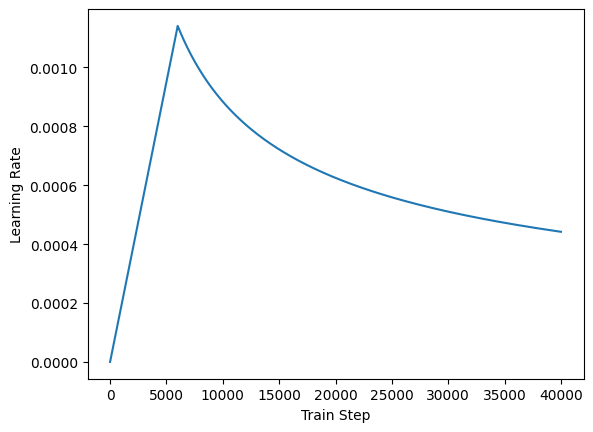

In [ ]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [ ]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [ ]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
earlyStop = EarlyStopping(monitor='val_loss',
    min_delta=0.001,
    patience=2,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0)

In [ ]:
transformer.fit(tf_train_data,
                epochs=20, verbose = 1 ,
                validation_data = tf_val_data,
                callbacks = [model_checkpoint_callback , earlyStop]
                )

Epoch 1/20
2000/2000 [==============================] - 599s 283ms/step - loss: 6.6028 - masked_accuracy: 0.1300 - val_loss: 4.6742 - val_masked_accuracy: 0.2697
Epoch 2/20
2000/2000 [==============================] - 530s 265ms/step - loss: 4.2347 - masked_accuracy: 0.3128 - val_loss: 3.7678 - val_masked_accuracy: 0.3681
Epoch 3/20
2000/2000 [==============================] - 536s 268ms/step - loss: 3.6068 - masked_accuracy: 0.3821 - val_loss: 3.2935 - val_masked_accuracy: 0.4353
Epoch 4/20
2000/2000 [==============================] - 533s 266ms/step - loss: 3.1802 - masked_accuracy: 0.4346 - val_loss: 2.9749 - val_masked_accuracy: 0.4805
Epoch 5/20
2000/2000 [==============================] - 529s 264ms/step - loss: 2.8534 - masked_accuracy: 0.4762 - val_loss: 2.7918 - val_masked_accuracy: 0.5046
Epoch 6/20
2000/2000 [==============================] - 533s 267ms/step - loss: 2.6417 - masked_accuracy: 0.5034 - val_loss: 2.7242 - val_masked_accuracy: 0.5154
Epoch 7/20
2000/2000 [======

In [ ]:
!tar -czvf model.tar.gz training_1/

training_1/
training_1/cp.ckpt.data-00000-of-00001
training_1/cp.ckpt.index
training_1/checkpoint


In [ ]:
from google.colab import files
files.download('model.tar.gz')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model = Transformers(num_layers=config['num_layers'] , d_model=config['d_model'] , num_heads=config['num_heads'],
                           dff = config['dff'] , input_vocab_size=config['en_vocab_size'] , target_vocab_size=config['vi_vocab_size']
                           , dropout_rate= config['dropout_rate'])

In [ ]:
output = model((en , vi))

In [ ]:
output.shape

TensorShape([32, 95, 62000])

In [ ]:
model.load_weights(checkpoint_path)

## Decoding

In [ ]:
def logsoftmax_sample(log_probs, temperature=1.0):  # pylint: disable=invalid-name
  """Returns a sample from a log-softmax output, with temperature.

  Args:
    log_probs: Logarithms of probabilities (often coming from LogSofmax)
    temperature: For scaling before sampling (1.0 = default, 0.0 = pick argmax)
  """
  # This is equivalent to sampling from a softmax with temperature.
  u = np.random.uniform(low=1e-6, high=1.0 - 1e-6, size=log_probs.shape)
  g = -np.log(-np.log(u))
  return np.argmax(log_probs + g * temperature, axis=-1)

### Next symbol

In [ ]:
def next_symbol(NMTAttn, input_tokens, cur_output_tokens, temperature):
    token_length = cur_output_tokens.numpy().shape[1] - 1
    output = NMTAttn((input_tokens , cur_output_tokens))
    log_probs = tf.nn.log_softmax(output[0, token_length, :])

    # get the next symbol by getting a logsoftmax sample (*hint: cast to an int)
    symbol = int(logsoftmax_sample(log_probs, temperature))

    ### END CODE HERE ###
    return symbol, float(log_probs[symbol])

### Sampling decode

In [ ]:
def sampling_decode(input_sentence, NMTAttn = None, temperature=0.0,next_symbol=next_symbol ,vietnamese_tokenizer = vietnamese_tokenizer, english_tokenizer = english_tokenizer ,token_en = 3 , token_start = 2 , max_length = 100):
  input_tokens = tf.constant(english_tokenizer(input_sentence,truncation=True ,max_length=216)['input_ids'])[tf.newaxis , :]
  cur_output_tokens = tf.constant([token_start])[tf.newaxis , :]
  cur_output = 0
  i= 0
  while cur_output != token_en and i < max_length:
    cur_output , prob = next_symbol(NMTAttn , input_tokens ,  cur_output_tokens , temperature)
    cur_output_tokens = tf.concat([cur_output_tokens , tf.constant([[cur_output]])], axis = -1)
    i+=1
  sentence = vietnamese_tokenizer.decode(cur_output_tokens.numpy()[0])
  return cur_output_tokens.numpy() , prob , sentence



In [ ]:
sampling_decode('what is your name?' , model , max_length = 10)

(array([[   2, 1760,  503,    8,  298,   11,  521,  417,    3]],
       dtype=int32),
 -0.004075436852872372,
 '[CLS] Cái tên của bạn là gì? [SEP]')

In [ ]:
sampling_decode("You are almost done with the assignment!" , model , max_length = 20)

(array([[   2, 1588,  309,   68,   16,   58,   14,  611,  211,  932,    3]],
       dtype=int32),
 -0.000849601230584085,
 '[CLS] Bạn gần như đã làm được bài tập! [SEP]')

### Generate samples

In [ ]:
def generate_samples(sentence, n_samples, NMTAttn=None, temperature=0.6,sampling_decode=sampling_decode, next_symbol=next_symbol,vietnamese_tokenizer = vietnamese_tokenizer, english_tokenizer = english_tokenizer ,token_en = 3 , token_start = 2 , max_length = 100):
  samples , log_probs = [] , []

    # run a for loop to generate n samples
  for _ in range(n_samples):

        # get a sample using the sampling_decode() function
        sample, log_prob , _ = sampling_decode(sentence, NMTAttn, temperature, next_symbol=next_symbol)

        # append the token list to the samples list
        samples.append(sample[0])
        log_probs.append(log_prob)

        # append the log probability to the log_probs list

  return samples , log_probs

### ROUGE-1

In [ ]:
from collections import Counter

def rouge1_similarity(system, reference):
    sys_counter = Counter(system)
    ref_counter = Counter(reference)

    overlap = 0

    # run a for loop over the sys_counter object (can be treated as a dictionary)
    for token in sys_counter:

        # lookup the value of the token in the sys_counter dictionary (hint: use the get() method)
        token_count_sys = sys_counter[token]

        # lookup the value of the token in the ref_counter dictionary (hint: use the get() method)
        token_count_ref = ref_counter[token]

        # update the overlap by getting the smaller number between the two token counts above
        overlap += token_count_sys if token_count_sys < token_count_ref else token_count_ref

    # get the precision
    precision = overlap/np.sum(list(sys_counter.values()))

    # get the recall
    recall = overlap/np.sum(list(ref_counter.values()))

    if precision + recall != 0:
        # compute the f1-score
        rouge1_score = 2*(precision*recall)/(precision+recall)
    else:
        rouge1_score = 0

    return rouge1_score

### average overlap

In [ ]:
def average_overlap(similarity_fn, samples, *ignore_params):
    # initialize dictionary
    scores = {}

    # run a for loop for each sample
    for index_candidate, candidate in enumerate(samples):

        # initialize overlap
        overlap = 0

        # run a for loop for each sample
        for index_sample, sample in enumerate(samples):

            # skip if the candidate index is the same as the sample index
            if index_candidate == index_sample:
                continue

            # get the overlap between candidate and sample using the similarity function
            sample_overlap = similarity_fn(candidate , sample)

            # add the sample overlap to the total overlap
            overlap += sample_overlap

        # get the score for the candidate by computing the average
        score = overlap/(len(samples)-1)

        # save the score in the dictionary. use index as the key.
        scores[index_candidate] = score

        ### END CODE HERE
    return scores

### weighted avg overlap

In [ ]:
def weighted_avg_overlap(similarity_fn, samples, log_probs):

    # initialize dictionary
    scores = {}

    # run a for loop for each sample
    for index_candidate, candidate in enumerate(samples):

        # initialize overlap and weighted sum
        overlap, weight_sum = 0.0, 0.0

        # run a for loop for each sample
        for index_sample, (sample, logp) in enumerate(zip(samples, log_probs)):

            # skip if the candidate index is the same as the sample index
            if index_candidate == index_sample:
                continue

            # convert log probability to linear scale
            sample_p = float(np.exp(logp))

            # update the weighted sum
            weight_sum += sample_p

            # get the unigram overlap between candidate and sample
            sample_overlap = similarity_fn(candidate, sample)

            # update the overlap
            overlap += sample_p * sample_overlap

        # get the score for the candidate
        score = overlap / weight_sum

        # save the score in the dictionary. use index as the key.
        scores[index_candidate] = score

    return scores

In [ ]:
def mbr_decode(sentence, n_samples, score_fn, similarity_fn, NMTAttn=None, temperature=0.6, generate_samples=generate_samples, sampling_decode=sampling_decode, next_symbol=next_symbol,vietnamese_tokenizer = vietnamese_tokenizer, english_tokenizer = english_tokenizer ,token_en = 3 , token_start = 2 , max_length = 100):
   samples , log_probs = generate_samples(sentence , n_samples , NMTAttn= NMTAttn , temperature = temperature)
   score =  score_fn(similarity_fn , samples , log_probs)
   index = list(score.keys())[np.argmax(list(score.values()))]
   return vietnamese_tokenizer.decode(samples[index][1:-1])


In [ ]:
mbr_decode('What is your name ?', 4 , weighted_avg_overlap,rouge1_similarity, model, max_length = 10)

'Tên của bạn là gì?'

In [ ]:
mbr_decode("this is a problem we have to solve .", 4 , weighted_avg_overlap,rouge1_similarity, model, max_length = 20)

'Đây là vấn đề chúng ta phải giải quyết.'

In [ ]:
mbr_decode("so i will just share with you some stories very quickly of some magical things that have happened.", 4 , weighted_avg_overlap,rouge1_similarity, model, temperature = 0.2, max_length = 20)

'Tôi sẽ chia sẻ với các bạn một vài câu chuyện rất nhanh chóng về một số điều kỳ diệu đã xảy ra.'

In [ ]:
mbr_decode("You are almost done the assignment!", 4 , weighted_avg_overlap,rouge1_similarity, model, max_length = 20)

'Bạn gần như đã làm được bài tập!'